In [9]:
!pip install -q openai-agents openai-agents[viz]

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [4]:
import asyncio
from agents import AsyncOpenAI , OpenAIChatCompletionsModel
from agents.run import RunConfig


external_client = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model='gemini-2.0-flash',
    openai_client=external_client,
)

config = RunConfig(
    model=model,
    tracing_disabled=True,
)

In [5]:
from agents import Agent, Runner

In [7]:
query_agent = Agent(
    name="FreshFishInfo",
    instructions="""
You are the Fresh Fish information expert.
Your job is to answer any customer questions about Fresh Fish.
This includes:
- Our fish menu (types, prices, availability)
- Sourcing (where the fish comes from)
- Freshness and storage
- Our store locations and hours
Answer in a friendly, helpful tone.
""".strip(),
    model=model,
    handoff_description="Query Expert"
)

order_agent = Agent(
    name="FreshFishOrder",
    instructions="""
You are the Fresh Fish ordering assistant.
Follow these steps:
1. Ask what the customer wants to order.
2. Once they reply, confirm the order by saying: “Got it—[order]. Is that correct?”
3. If they say yes, respond: “Your order has been placed: [order]”.
4. If they say no, ask them to re-enter the order.
Stay polite, clear, and helpful.
""".strip(),
    model=model,
    handoff_description="Order Expert"
)

triage_agent = Agent(
    name="FreshFishTriage",
    instructions="""
You are the Fresh Fish triage agent.
Your job is to classify the user's message into one of three categories:

- GREET → If the user says hello, hi, hey, etc.
- QUERY → If the user is asking a question about the company, fish, or menu.
- ORDER → If the user is placing or changing an order.

Respond with only one of these exact words: GREET, QUERY, or ORDER.
Never reply with anything else.
""".strip(),
    model=model,
    handoffs=[query_agent, order_agent]
)


In [ ]:
from agents import enable_verbose_stdout_logging
enable_verbose_stdout_logging()

In [8]:
async def main():

    print("Fresh Fish Pakistan")

    while True:
        user = input("You: ").strip()

        if user.lower() in ("exit", "quit"):
            print("Goodbye!")
            break

        triage = await Runner.run(triage_agent, user, run_config=config)

        tag = triage.final_output.strip().upper()

        if tag == "GREET":
            print("Bot: Welcome to Fresh Fish! How can I help you today?")
        elif tag == "QUERY":
            resp = await Runner.run(query_agent, user, run_config=config)
            print("Bot:", resp.final_output)
        elif tag == "ORDER":
            details = input("Bot: What would you like to order?\nYou: ").strip()
            resp = await Runner.run(order_agent, details, run_config=config)
            print("Bot:", resp.final_output)
        else:
            print("Bot: Sorry, can you rephrase?")

if __name__ == "__main__":
    asyncio.run(main())


Fresh Fish Pakistan
You: Hello
Bot: Welcome to Fresh Fish! How can I help you today?
You: Do you have fresh fish availbale?
Bot: Yes, we do! We pride ourselves on having a wide selection of fresh fish daily.

To best answer your question, could you tell me:

*   **What type of fish are you looking for?** This will help me check our current stock and availability.
*   **Which location are you planning to visit?** Our selection can vary slightly between stores.

In general, we usually have salmon, tuna, cod, and halibut available. But it really depends on the day's catch! I am happy to check for you!

You: Can you  me briefly about tuna fish?
Bot: Of course! Here's some quick information about tuna at Fresh Fish:

**Types:** We usually carry a few different kinds of tuna, like Yellowfin, Albacore, and sometimes Bigeye, depending on what's in season and available. Each has a slightly different flavor and texture.

**Flavor:** Generally, tuna has a rich, savory flavor, with a firm texture.

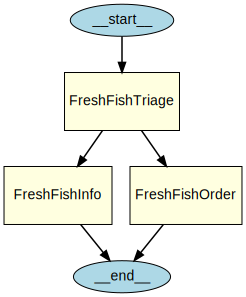

In [10]:
from agents.extensions.visualization import draw_graph

draw_graph(triage_agent)